In [ ]:
import os
import contextlib
import gc
import itertools
import pickle
import tensorflow               as tf
import matplotlib.pyplot        as plt
import numpy                    as np
import seaborn                  as sns
from sklearn.metrics.pairwise   import cosine_similarity
from skimage.segmentation       import mark_boundaries
from lime                       import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [3]:
class_labels = {
    0 : 'cat',
    1 : 'dog',
}
class_labels = list(class_labels.values())

In [4]:
test_set = tf.data.Dataset.load('test_set')
test_set = test_set.shuffle(256)

2024-11-05 05:45:24.847380: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
model_extrcs = []
save_dir     = "models/diff_extrcs"

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_extrcs.append(model)

In [6]:
for model_file in model_extrcs:
    print(model_file.name)

Inception-CvD
Densenet-CvD
Xception_CvD
ResNet-CvD


In [7]:
extrc_names = ["Xception", "InceptionV3", "DenseNet121", "ResNet50V2"]

for i, model in enumerate(model_extrcs):
    model._name = extrc_names[i]
    print(model.name)

Xception
InceptionV3
DenseNet121
ResNet50V2


In [ ]:
import helper

samples = [helper.get_sample(i, test_set) for i in range(2)]

In [9]:
for ls in samples:
    print(len(ls))

890
966


Iteration : 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Class : cat
Explaining Class: cat
Iteration : 2


  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Class : cat
Explaining Class: cat


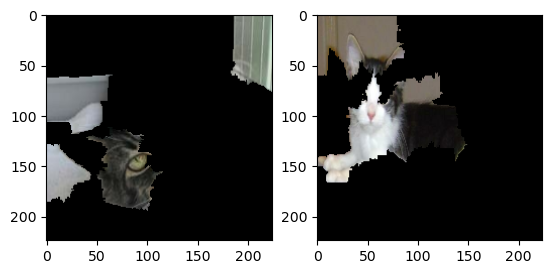

In [33]:
expls_cat = LIME.explanation_fn(cat_samples[:2], model_extrcs[0])

temp_cat, _,_ = expls_cat

for i, temp in enumerate(temp_cat):
    plt.subplot(1,2,i+1)
    plt.imshow(temp)

Iteration : 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Class : dog
Explaining Class: dog
Iteration : 2


  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Class : dog
Explaining Class: dog


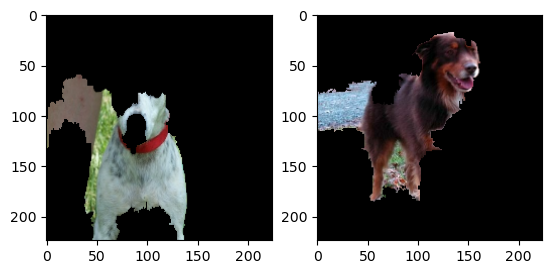

In [34]:
expls_dog = LIME.explanation_fn(dog_samples[:2], model_extrcs[0])

temp_dog, _,_ = expls_dog

for i, temp in enumerate(temp_dog):
    plt.subplot(1,2,i+1)
    plt.imshow(temp)

In [10]:
preds_extrcs   = [helper.get_predictions(model_extrcs, sample_list[:100]) for sample_list in samples] # process only 100 instances
samples_extrcs = [helper.filter_correct_predictions(prediction) for prediction in preds_extrcs]

Wrong Prediction at index 4 by Xception: Predicted cat, True dog
Wrong Prediction at index 13 by InceptionV3: Predicted cat, True dog
Wrong Prediction at index 22 by InceptionV3: Predicted cat, True dog
Wrong Prediction at index 33 by DenseNet121: Predicted cat, True dog
Wrong Prediction at index 68 by Xception: Predicted cat, True dog
Wrong Prediction at index 71 by Xception: Predicted cat, True dog
Wrong Prediction at index 75 by ResNet50V2: Predicted cat, True dog
Wrong Prediction at index 89 by DenseNet121: Predicted cat, True dog
Wrong Prediction at index 90 by DenseNet121: Predicted cat, True dog


In [ ]:
%%time
importlib.reload(LIME)

save_directory = 'LIME Expls/diff_extrcs'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_explanations(samples_extrcs, model_extrcs, save_directory)

50


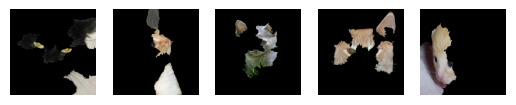

In [43]:
with open('LIME Expls/diff_extrcs/explain_cat_DenseNet121.pkl', 'rb') as file:
    temp, _,_ = pickle.load(file)

print(len(temp))
for i, img in enumerate(temp[:5]):
    plt.subplot(1,5, i +1)
    plt.imshow(img)
    plt.axis('off')

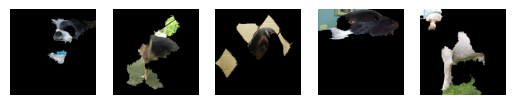

In [39]:
with open('LIME Expls/diff_extrcs/explain_dog_DenseNet121.pkl', 'rb') as file:
    temp, _,_ = pickle.load(file)

for i, img in enumerate(temp[:5]):
    plt.subplot(1,5, i +1)
    plt.imshow(img)
    plt.axis('off')

In [40]:
model_opts     = []
save_directory = 'models/diff_opts/'

for model_file in os.listdir(save_directory):
    if model_file.endswith('.h5'):
        model_path = os.path.join(save_directory, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_opts.append(model)

In [41]:
preds_opts   = [helper.get_predictions(model_opts, sample_list[:100]) for sample_list in samples] # process only 100 instances
samples_opts = [helper.filter_correct_predictions(prediction) for prediction in preds_opts]

Wrong Prediction at index 61 by DenseNet-SGD: Predicted dog, True cat
Wrong Prediction at index 13 by DenseNet-SGD: Predicted cat, True dog
Wrong Prediction at index 22 by DenseNet-Nadam: Predicted cat, True dog
Wrong Prediction at index 95 by DenseNet-Adam: Predicted cat, True dog


In [ ]:
%%time
save_directory = 'LIME Expls/diff_opts'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_explanations(samples_opts, model_opts, save_directory)

In [45]:
# Models of Different seeds
model_seeds    = []

save_directory = "models/diff_seeds/"

for model_file in os.listdir(save_directory):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_directory, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_seeds.append(model)

In [46]:
for i, model in enumerate(model_seeds):
    model._name = f'Dense{i+1}'
    print(model.name)

Dense1
Dense2
Dense3
Dense4
Dense5
Dense6
Dense7
Dense8
Dense9
Dense10


In [47]:
preds_seeds   = [helper.get_predictions(model_seeds, sample_list[:100]) for sample_list in samples] # process only 100 instances
samples_seeds = [helper.filter_correct_predictions(prediction) for prediction in preds_seeds]

Wrong Prediction at index 13 by Dense2: Predicted cat, True dog
Wrong Prediction at index 22 by Dense1: Predicted cat, True dog
Wrong Prediction at index 68 by Dense5: Predicted cat, True dog
Wrong Prediction at index 95 by Dense2: Predicted cat, True dog


In [ ]:
%%time
save_directory = 'LIME Expls/diff_seeds'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_explanations(samples_seeds, model_seeds, save_directory)

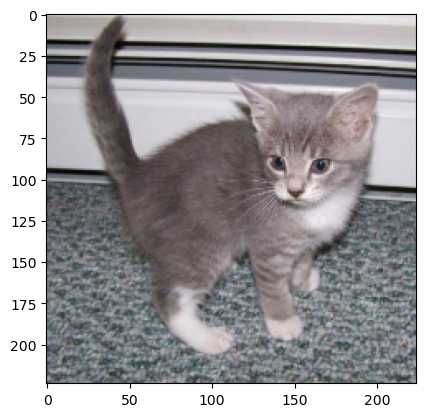

In [118]:
cat_samples = helper.get_sample(0, test_set)
# dog_samples = helper.get_sample(1, test_set)

image, label = next(iter(cat_samples))

plt.imshow(image)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

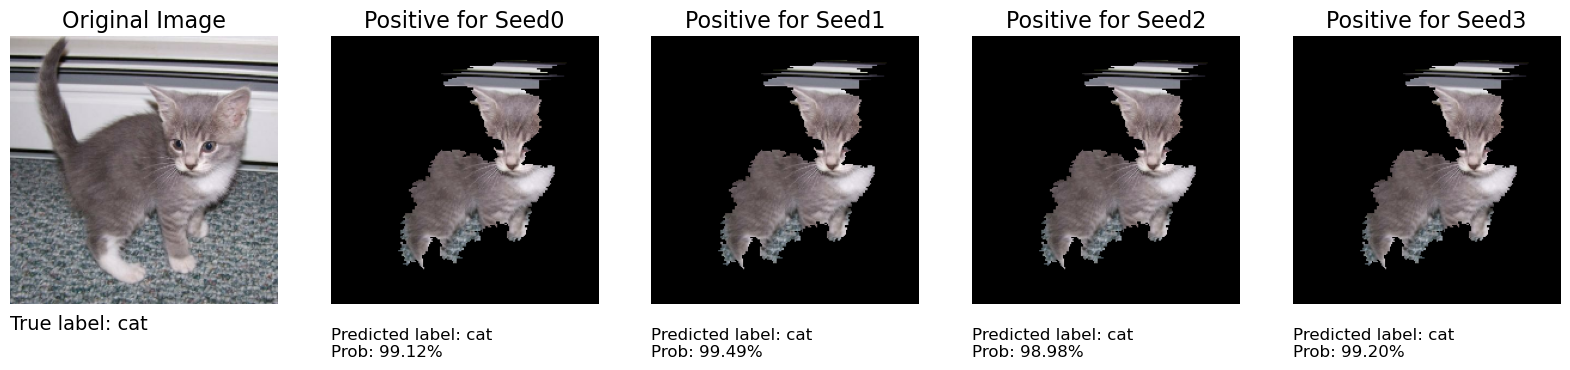

In [119]:
expl_temp = []
expl_mask = []

plt.figure(figsize = (20,20))
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title(f'Original Image', fontsize=16)
plt.text(0,-0.1,
            f'True label: {class_labels[label]}',
            fontsize  = 14,
            transform = plt.gca().transAxes)
plt.axis('off')

for model_idx, model in enumerate(model_seeds[:4]):
    temp, mask,_ = LIME.explain_aninstance(image, model)
    pred         = LIME.prediction_fn(img, model)
    pred_label   = class_labels[np.argmax(pred)]
    prob         = np.max(pred) * 100
    expl_temp.append(temp)
    expl_mask.append(mask)
    
    plt.subplot(1, 5, model_idx+2)
    plt.imshow(temp)
    plt.title(f'Positive for Seed{model_idx}', fontsize = 16)
    plt.text(0,-0.2,
            f'Predicted label: {pred_label}\nProb: {prob:.2f}%',
            fontsize  = 12,
            transform = plt.gca().transAxes)
    plt.axis('off')

plt.show()